# Coding Notebook 4: FCNN TO RNN MNIST

By Dylan Louie

Today we will be converting a FCNN that takes in the whole image flattened at once to a RNN that takes in rows to learn about inputting sequential data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms

## 1. Set Device And Datatypes For Your Neural Network and Pytorch Tensors

In [2]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

## 2. Download the MNIST Dataset from torchvision

https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html

In [3]:
# path to where data is saced
data_path='/tmp/data/mnist'

# using torchvision.datasets to get MNIST
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [4]:
print(type(trainset))
print(f"The length of the training dataset is {len(trainset)}")
print(f"The length of the test dataset is {len(testset)}")
print()

# get the first tuple of the trainset (image, label)
print(type(trainset[0]))
print(type(trainset[0][0]), type(trainset[0][1]))
print(trainset[0][0].shape)

<class 'torchvision.datasets.mnist.MNIST'>
The length of the training dataset is 60000
The length of the test dataset is 10000

<class 'tuple'>
<class 'torch.Tensor'> <class 'int'>
torch.Size([1, 28, 28])


## 3. Display the dataset with matplotlib

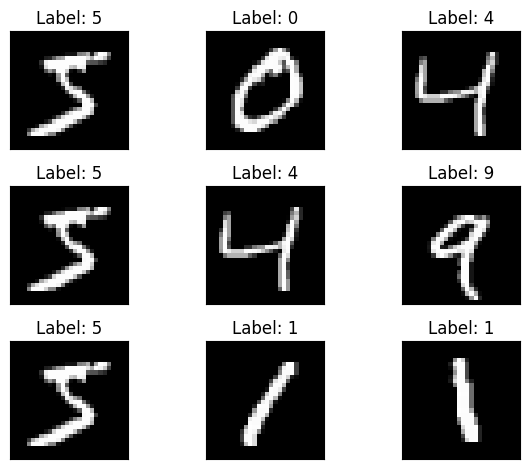

In [5]:
def display_trainset(trainset, rows=3, columns=3):
    fig, ax = plt.subplots(rows, columns)

    # iterate through the specified rows and columns of the figure
    for i in range(rows):
        for j in range(columns):

            # display the image
            # needs to be HxWxC
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
            ax[i, j].imshow(torch.permute(trainset[i*j + j][0], (1, 2, 0)), cmap='gray')

            # add a title which is the label
            ax[i, j].set_title('Label: ' + str(trainset[i*j + j][1]))

            # Hide axes ticks
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])

    plt.tight_layout()
    plt.show()

display_trainset(trainset)

# 4. Wrap the dataset in a Dataloader

Dataloaders are an effecient way to iterate and load the dataset, they have additional utility such as batching and shuffling.

https://docs.pytorch.org/docs/stable/data.html

In [6]:
from torch.utils.data import DataLoader

In [7]:
# Create DataLoaders
batch_size = 128

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=True)

In [8]:
print(f"The length of the train loader after batching and shuffling: {len(train_loader)}")
print(f"The length of the train loader * batch size: {len(train_loader)*batch_size}\n")
print(f"The length of the trainset: {len(trainset)}")

print("The length of the test loader after batching and shuffling: {len(test_loader)}")
print(f"The length of the test loader * batch size: {len(test_loader)*batch_size}")
print(f"The length of the testset: {len(testset)}")

The length of the train loader after batching and shuffling: 468
The length of the train loader * batch size: 59904

The length of the trainset: 60000
The length of the test loader after batching and shuffling: {len(test_loader)}
The length of the test loader * batch size: 9984
The length of the testset: 10000


https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

The dataloader returns an `iterable` meaning we can't directly index and only iterate over it

In [9]:
try:
    train_loader[0]
except Exception as e:
    print(f"Error: {e}")

Error: 'DataLoader' object is not subscriptable


In [10]:
images, targets = next(iter(train_loader))

print(images.shape)  # batch, channels, H, W
print(targets.shape)  # batch

torch.Size([128, 1, 28, 28])
torch.Size([128])


## 5. Make Model

In [11]:
# Hyper Parameters

hidden_size = 128
num_classes = 10
num_epochs = 2
learning_rate = 1e-3

input_size = 28
sequence_length = 28
num_layers = 2

In [19]:
# deine nn
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()

        # Save hyperparameters
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        #define layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # x dims --> batch_size, sequence length, input size/features

        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x):

        # define initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # feed in input and hidden state into the rnn
        out, _ = self.rnn(x, h0)


        # out: batch_size, seq_length, hidden size
        # out: (N, 28, 28)
        # get the last sequence output
        out = out[:, -1, :]

        # out (N, 128)
        out = self.fc(out)


        return out

In [30]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()

        # Save hyperparameters
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        #define layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # x dims --> batch_size, sequence length, input size/features

        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x):

        # define initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # feed in input and hidden state into the rnn
        out, _ = self.rnn(x, h0)


        # out: batch_size, seq_length, hidden size
        # out: (N, 28, 28)
        # get the last sequence output
        out = out[:, -1, :]

        # out (N, 128)
        out = self.fc(out)


        return out

In [51]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()

        # Save hyperparameters
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        #define layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # x dims --> batch_size, sequence length, input size/features

        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x):

        # define initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # feed in input and hidden state into the rnn
        out, _ = self.rnn(x, (h0, c0))


        # out: batch_size, seq_length, hidden size
        # out: (N, 28, 28)
        # get the last sequence output
        out = out[:, -1, :]

        # out (N, 128)
        out = self.fc(out)


        return out

In [52]:
model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Show Softmax of Logits Before Training

In [53]:
model.eval()

# get the first batch
images, targets = next(iter(train_loader))

# could also use
images = images.reshape(-1, 28, 28)

logits = model(images)

print(logits.shape)
print(logits)

torch.Size([128, 10])
tensor([[ 0.0592,  0.0143,  0.0440,  ..., -0.0505,  0.0893, -0.0530],
        [ 0.0593,  0.0153,  0.0442,  ..., -0.0549,  0.0904, -0.0570],
        [ 0.0589,  0.0155,  0.0435,  ..., -0.0515,  0.0893, -0.0542],
        ...,
        [ 0.0563,  0.0176,  0.0409,  ..., -0.0579,  0.0903, -0.0595],
        [ 0.0573,  0.0156,  0.0417,  ..., -0.0574,  0.0906, -0.0575],
        [ 0.0472,  0.0226,  0.0358,  ..., -0.0597,  0.0886, -0.0635]],
       grad_fn=<AddmmBackward0>)


torch.Size([128, 10])
tensor([[0.1055, 0.1009, 0.1039,  ..., 0.0946, 0.1088, 0.0943],
        [0.1056, 0.1010, 0.1040,  ..., 0.0942, 0.1089, 0.0940],
        [0.1055, 0.1010, 0.1039,  ..., 0.0945, 0.1088, 0.0942],
        ...,
        [0.1054, 0.1013, 0.1037,  ..., 0.0940, 0.1090, 0.0938],
        [0.1054, 0.1011, 0.1038,  ..., 0.0940, 0.1090, 0.0940],
        [0.1046, 0.1021, 0.1034,  ..., 0.0940, 0.1091, 0.0937]],
       grad_fn=<SoftmaxBackward0>)
tensor([0.1055, 0.1009, 0.1039, 0.0968, 0.0950, 0.1019, 0.0983, 0.0946, 0.1088,
        0.0943], grad_fn=<SelectBackward0>)


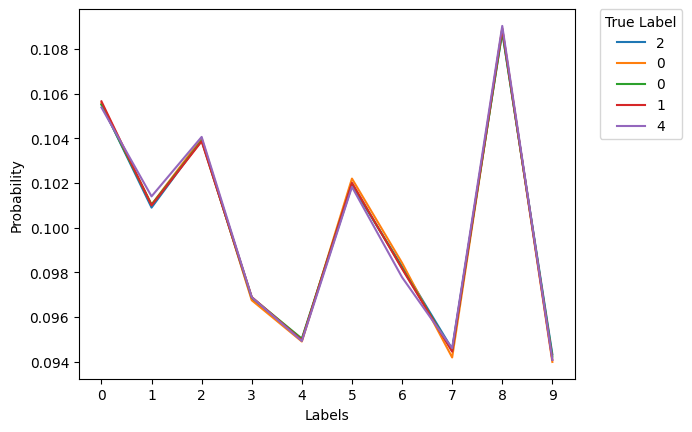

In [54]:
# apply softmax to logits
output = F.softmax(logits, dim=1)

print(output.shape)
print(output)
print(output[0])

with torch.no_grad():
    for i in range(5):
        x = np.arange(output.shape[1])
        y = output[i]
        plt.plot(x, y, label=f"{targets[i]}")

        plt.xlabel("Labels")
        plt.ylabel("Probability")

plt.xticks(np.arange(output.shape[1]))
plt.legend(title="True Label", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

## 6. Training Loop

1. Feed data into the neural network and get the predicted label
2. Compare the predicted label and the true label using a loss function
3. Calculate the gradients of the weights + bias with respect to the loss
4. Update the weights + bias using backpropogation
5. Repeat

In [55]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 2
loss_hist = []
test_acc_hist = []
counter = 0
loss_fn = nn.CrossEntropyLoss()

model.train()

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for i, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        data = data.reshape( -1,28,28)
        output = model(data)

        # initialize the loss & sum over time
        loss_val = loss_fn(output, targets)

        # Gradient calculation + weight update
        loss_val.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print loss
        if i % 100 == 0:
            print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.4f}")

Epoch 0, Iteration 0 
Train Loss: 2.2995
Epoch 0, Iteration 100 
Train Loss: 0.7277
Epoch 0, Iteration 200 
Train Loss: 0.3303
Epoch 0, Iteration 300 
Train Loss: 0.1384
Epoch 0, Iteration 400 
Train Loss: 0.1562
Epoch 1, Iteration 0 
Train Loss: 0.2342
Epoch 1, Iteration 100 
Train Loss: 0.1231
Epoch 1, Iteration 200 
Train Loss: 0.0723
Epoch 1, Iteration 300 
Train Loss: 0.2260
Epoch 1, Iteration 400 
Train Loss: 0.1400


# 7. Results

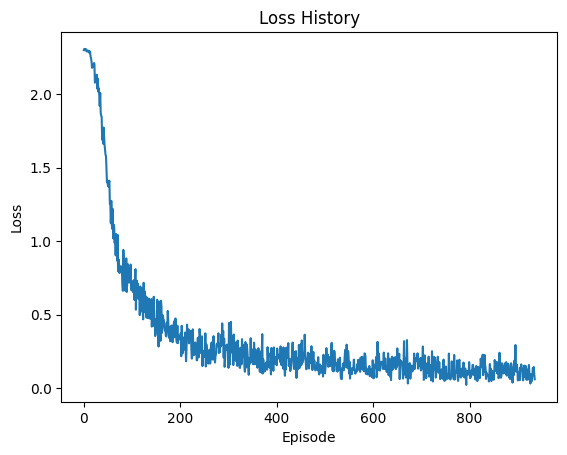

In [56]:
# Plot Loss
fig = plt.figure(facecolor='w')
plt.plot(loss_hist)
plt.title("Loss History")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.show()

In [57]:
# Set model to evaluation mode
model.eval()

# Tracking variables
total_loss = 0.0
total_correct = 0
total_samples = 0

# Optional: store loss per batch if you want to plot later
test_loss_hist = []

with torch.no_grad():
    for i, (data, targets) in enumerate(test_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        data = data.reshape(-1, 28, 28)
        outputs = model(data)
        loss = loss_fn(outputs, targets)

        # Track loss and accuracy
        batch_size = data.size(0)
        total_loss += loss.item() * batch_size
        total_correct += (outputs.argmax(1) == targets).sum().item()
        total_samples += batch_size
        test_loss_hist.append(loss.item())

        if i % 10 == 0:
            print(f"[Batch {i}] Test Loss: {loss.item():.4f}")

# Final metrics
avg_loss = total_loss / total_samples
accuracy = total_correct / total_samples

print(f"\nFinal Evaluation — Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4%}")

[Batch 0] Test Loss: 0.0697
[Batch 10] Test Loss: 0.1585
[Batch 20] Test Loss: 0.2158
[Batch 30] Test Loss: 0.0801
[Batch 40] Test Loss: 0.0458
[Batch 50] Test Loss: 0.0488
[Batch 60] Test Loss: 0.0170
[Batch 70] Test Loss: 0.1818

Final Evaluation — Average Loss: 0.1152, Accuracy: 96.3742%


# Show Logit Softmax After Training

In [58]:
model.eval()

# get the first batch
images, targets = next(iter(train_loader))

# could also use
images = images.reshape(-1, 28, 28)

logits = model(images)

print(logits.shape)
print(logits)

torch.Size([128, 10])
tensor([[-1.6196e+00, -7.8657e-01, -5.0867e-01,  ..., -1.8016e+00,
          1.2941e+00, -1.0924e+00],
        [-2.8377e+00, -4.5427e-01,  1.7605e+00,  ...,  9.6666e+00,
         -1.1003e+00,  1.7265e+00],
        [-2.9004e-01, -2.9961e-01,  7.5783e+00,  ..., -9.0598e-02,
          7.7382e-03, -2.6817e+00],
        ...,
        [-3.7535e-01, -2.6784e+00, -1.6433e+00,  ..., -3.0068e+00,
          7.2264e+00,  1.1488e+00],
        [-1.5802e+00, -3.4126e+00, -7.2178e-01,  ..., -4.1470e-01,
          1.1374e+00,  5.9695e+00],
        [-3.3983e+00,  1.0666e+00,  1.0577e+00,  ...,  4.5460e+00,
          8.0212e-01, -5.6295e-01]], grad_fn=<AddmmBackward0>)


torch.Size([128, 10])
tensor([[5.9370e-04, 2.9123e-05, 2.8271e-04,  ..., 7.1534e-03, 4.6111e-04,
         9.7779e-01],
        [3.6707e-05, 2.1301e-03, 1.0016e-03,  ..., 4.9787e-04, 2.9727e-03,
         1.0073e-02],
        [6.7842e-04, 1.2744e-03, 1.0640e-03,  ..., 7.6037e-04, 9.8176e-01,
         8.9418e-04],
        ...,
        [1.1705e-03, 7.1083e-04, 2.3698e-03,  ..., 4.5226e-04, 2.8800e-04,
         4.8921e-05],
        [1.6154e-04, 6.9499e-04, 7.4605e-05,  ..., 9.8533e-01, 3.5165e-04,
         9.5838e-03],
        [8.3492e-05, 1.8983e-04, 1.4103e-05,  ..., 1.1449e-03, 8.8477e-04,
         9.6040e-01]], grad_fn=<SoftmaxBackward0>)
tensor([5.9370e-04, 2.9123e-05, 2.8271e-04, 1.1193e-04, 1.2584e-02, 6.5781e-04,
        3.3365e-04, 7.1534e-03, 4.6111e-04, 9.7779e-01],
       grad_fn=<SelectBackward0>)


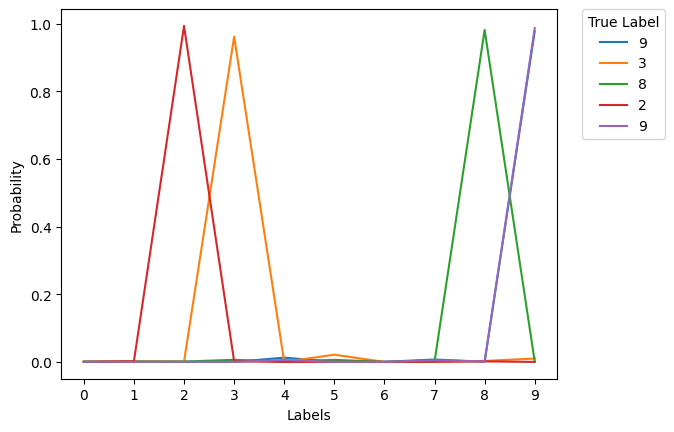

In [29]:
# apply softmax to logits
output = F.softmax(logits, dim=1)

print(output.shape)
print(output)
print(output[0])

with torch.no_grad():
    for i in range(5):
        x = np.arange(output.shape[1])
        y = output[i]
        plt.plot(x, y, label=f"{targets[i]}")

        plt.xlabel("Labels")
        plt.ylabel("Probability")

plt.xticks(np.arange(output.shape[1]))
plt.legend(title="True Label", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# 8. Try Having the Model Classify a Digit You Drew Yourself

In [23]:
import os

In [24]:
os.listdir()

['.config', 'data', 'sample_data']

In [25]:
from PIL import Image

In [26]:
# Load the PNG image using PIL
image_path = os.path.join('Numba_Seven.png')
png_image = Image.open(image_path)

# Define transformation to convert image to tensor
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

# Apply the transformation and normalize the image
tensor_image = transform(png_image)

# Display tensor shape and data type
print(f"Tensor shape: {tensor_image.shape}")
print(f"Tensor data type: {tensor_image.dtype}")

# Optional: Visualize the tensor (convert tensor back to numpy array for plotting)
numpy_image = tensor_image.numpy()
plt.imshow(numpy_image.transpose(1, 2, 0), cmap='gray')  # Transpose to (H, W, C) for matplotlib
plt.axis('off')
plt.show()

# add batch dimension
tensor_image = tensor_image.unsqueeze(0)

FileNotFoundError: [Errno 2] No such file or directory: 'Numba_Seven.png'

In [ ]:
model.eval()
tensor_image = tensor_image.reshape( -1, 28, 28)
pred = model(tensor_image)
print(f"The model predicts that the image is a {pred.argmax().item()}")

## Congrats for Finishing!